In [1]:
!nvidia-smi

Mon Oct 30 12:05:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
!pip install datasets -U
!pip install transformers -U
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 67.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.0
    Uninstalling transformers-4.33.0:
      Successfully uninstalled transformers-4.33.0
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0117d6ed355417f421620f924c21513ff92f985b0ca5e959b19b7dc6c3c1e0d5
  Stored in directory: /

In [3]:
# !pip show datasets
# !pip show transformers

In [171]:
import torch
import time
from transformers import LEDTokenizer, LEDForConditionalGeneration,AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from datasets import load_dataset, load_metric, Dataset


In [ ]:
led_tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

In [5]:
book_data = load_dataset("ubaada/booksum-complete-cleaned", "books")
chapter_data = load_dataset("ubaada/booksum-complete-cleaned", "chapters")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [6]:
[chapter_data, book_data]

[DatasetDict({
     train: Dataset({
         features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate'],
         num_rows: 5653
     })
     test: Dataset({
         features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate'],
         num_rows: 950
     })
     validation: Dataset({
         features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate'],
         num_rows: 854
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['bid', 'title', 'text', 'summary'],
         num_rows: 151
     })
     test: Dataset({
         features: ['bid', 'title', 'text', 'summary'],
         num_rows: 17
     })
     validation: Dataset({
         features: ['bid', 'title', 'text', 'summary'],
         num_rows: 19
     })
 })]

In [7]:
def keep_only_one_summary(datadict):
    for split in datadict:
        df = datadict[split].to_pandas()
        a_summary = df["summary"].apply(lambda x: x[0]["text"]).to_numpy()
        datadict[split] = datadict[split].add_column("a_summary", a_summary)      

In [8]:
keep_only_one_summary(book_data)
keep_only_one_summary(chapter_data)

In [9]:
[chapter_data, book_data]

[DatasetDict({
     train: Dataset({
         features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary'],
         num_rows: 5653
     })
     test: Dataset({
         features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary'],
         num_rows: 950
     })
     validation: Dataset({
         features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary'],
         num_rows: 854
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['bid', 'title', 'text', 'summary', 'a_summary'],
         num_rows: 151
     })
     test: Dataset({
         features: ['bid', 'title', 'text', 'summary', 'a_summary'],
         num_rows: 17
     })
     validation: Dataset({
         features: ['bid', 'title', 'text', 'summary', 'a_summary'],
         num_rows: 19
     })
 })]

In [121]:
train_chapterdataset = chapter_data["train"]
val_chapterdataset = chapter_data["validation"]
test_chapterdataset = chapter_data["test"]

In [122]:
def remove_large_texts_by_tokensize(dataset, quantile_val=0.5):
    df = dataset.to_pandas()
    df["token_len"] = df["text"].apply(lambda x: len(led_tokenizer.encode(x)))
    qunatile_lim = df["token_len"].quantile(quantile_val)
    df = df[df["token_len"] <= qunatile_lim]
    new_dataset = Dataset.from_pandas(df)
    return new_dataset

In [123]:
def add_token_len_to_sums(dataset):
    df = dataset.to_pandas()
    df["sum_token_len"] = df["a_summary"].apply(lambda x: len(led_tokenizer.encode(x)))
    new_dataset = Dataset.from_pandas(df)
    return new_dataset

In [126]:
test_chapterdataset

Dataset({
    features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary'],
    num_rows: 950
})

In [125]:
remove_large_texts_by_tokensize(test_chapterdataset)

Dataset({
    features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary', 'token_len', '__index_level_0__'],
    num_rows: 476
})

In [127]:
train_chapterdataset = remove_large_texts_by_tokensize(train_chapterdataset)
val_chapterdataset = remove_large_texts_by_tokensize(val_chapterdataset)
test_chapterdataset = remove_large_texts_by_tokensize(test_chapterdataset)

In [128]:
train_chapterdataset

Dataset({
    features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary', 'token_len', '__index_level_0__'],
    num_rows: 2827
})

In [129]:
train_chapterdataset = add_token_len_to_sums(train_chapterdataset)
val_chapterdataset = add_token_len_to_sums(val_chapterdataset)
test_chapterdataset = add_token_len_to_sums(test_chapterdataset)

In [108]:
chapter_data["train"].to_pandas()["summary"].apply(lambda x: x[0]["text"])

0       Before any characters appear, the time and geo...
1       In another part of the forest by the river a f...
2       When the mounted party from Fort Howard approa...
3       The pursuit of Magua is unsuccessful, but Hawk...
4       Heyward and the girls are uneasy and Gamut is ...
                              ...                        
5648    Before Isabel leaves Rome, she goes to see Pan...
5649    Isabel is greeted by Henrietta Stackpole at Ch...
5650    Isabel arrives at Gardencourt. The house is ve...
5651    Isabel remembers that when she first came to G...
5652    Beowulf begins with the legends of the warrior...
Name: summary, Length: 5653, dtype: object

In [130]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=4):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [131]:
show_random_elements(train_chapterdataset, 1)

In [132]:
from transformers import AutoTokenizer

In [133]:
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

In [150]:
df = train_chapterdataset.to_pandas()

In [151]:
df["token_len"]

0       4612
1       4524
2       4556
3       4612
4       4524
        ... 
2822    3594
2823    4465
2824    4419
2825    4258
2826    4631
Name: token_len, Length: 2827, dtype: int64

In [153]:
df["token_len"].describe()

count    2827.000000
mean     2666.289706
std      1208.142728
min       102.000000
25%      1718.500000
50%      2698.000000
75%      3676.500000
max      4716.000000
Name: token_len, dtype: float64

In [138]:
df['sum_token_len'].mean()

367.7396533427662

In [139]:
df['sum_token_len'].describe()

count    2827.000000
mean      367.739653
std       258.605421
min         2.000000
25%       193.000000
50%       310.000000
75%       472.000000
max      2669.000000
Name: sum_token_len, dtype: float64

In [143]:
df["a_summary"].apply(len).value_counts()

a_summary
903     6
1385    6
1199    6
608     6
994     6
       ..
251     1
648     1
223     1
519     1
2327    1
Name: count, Length: 1868, dtype: int64

In [147]:
df[df["sum_token_len"] == 2]["summary"][833][0]

{'analysis': 'In this essay, more than any other besides perhaps 51, Madison lays out his philosophy on free government. Madison does not state in the Federalist how the state of nature is abandoned and government created. We may assume, however, that his opinion does not differ here from what has been called the core of his philosophy, namely the compact theory of the foundation of the state. This theory was generally accepted at the time the essays were written, whereas the organic theory was hardly known. Madison adhered to it even when it was being abandoned by most European theorists, and called it a "fundamental principle of free government." Furthermore, the acceptance of the compact theory in the Federalist can be concluded from the fact that Madison, who recognizes a parallel between the formation of the state by individuals and the formation of a confederacy by state, calls the Confederation "a compact among the States." Madison\'s view on the relation between people and gove

In [154]:
max_input_length = 4716
max_output_length = 400
batch_size = 1

In [155]:
def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["a_summary"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

In [156]:
train_chapterdataset

Dataset({
    features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary', 'token_len', '__index_level_0__', 'sum_token_len'],
    num_rows: 2827
})

In [158]:
train_dataset = train_chapterdataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary'],
)

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

In [159]:
val_dataset = val_chapterdataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary'],
)

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

In [160]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [161]:
from transformers import AutoModelForSeq2SeqLM

In [162]:
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

In [163]:
# set generate hyperparameters
led.config.num_beams = 4
led.config.max_length = 512
led.config.min_length = 100
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

In [164]:
rouge = load_metric("rouge")

In [172]:
def compute_metrics(pred):
    start = time.time()
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid
    end = time.time()
    print(end - start)
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [166]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [177]:
# enable fp16 apex training
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    output_dir="./",
    logging_steps=5,
    eval_steps=4,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
)

In [178]:
trainer = Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


# Evaluation

In [49]:
led_tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

<bound method PreTrainedTokenizerBase.encode of LEDTokenizerFast(name_or_path='allenai/led-base-16384', vocab_size=50265, model_max_length=16384, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}>

In [12]:
test_chapterdataset = chapter_data["train"]

In [13]:
device="cuda:0"

In [95]:
test_chapterdataset_sub = test_chapterdataset.to_pandas()

In [54]:
len(test_chapterdataset_sub["text"][0])

40844

In [56]:
len(led_tokenizer.encode(x["text"][0]))

9758

In [60]:
test_chapterdataset_sub["token_lens"] = test_chapterdataset_sub["text"].apply(lambda x: len(led_tokenizer.encode(x)))

In [62]:
# token_lens.describe()
# count      5653.000000
# mean       7189.320538
# std        8463.803514
# min         102.000000
# 25%        2698.000000
# 50%        4716.000000
# 75%        8602.000000
# max      201855.000000

count      5653.000000
mean       7189.320538
std        8463.803514
min         102.000000
25%        2698.000000
50%        4716.000000
75%        8602.000000
max      201855.000000
Name: text, dtype: float64

In [64]:
# token_lens.quantile(0.5)
# 4716.0 This is the token size of the 50th quantile

4716.0

In [66]:
token_lens

0        9758
1        4800
2        4721
3        4993
4        5947
        ...  
5648     5815
5649     4631
5650     5519
5651     7853
5652    88653
Name: text, Length: 5653, dtype: int64

<Axes: >

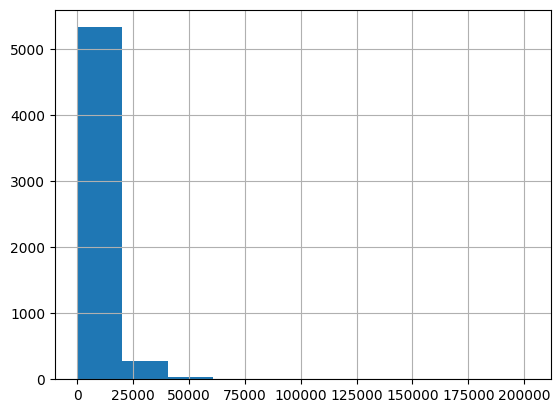

In [65]:
token_lens.hist()

In [101]:
test_chapterdataset_sub[token_lens == 4716]["text"].apply(len)

4143    15405
Name: text, dtype: int64

In [16]:
# quantile_50 = test_chapterdataset_sub["text"].apply(lambda x: len(x)).quantile(0.50)

In [70]:
 test_chapterdataset_sub = test_chapterdataset_sub[token_lens <= 4716]

In [71]:
test_chapterdataset_sub = Dataset.from_pandas(test_chapterdataset_sub)

In [72]:
test_sub = test_chapterdataset_sub.select(range(10))

In [73]:
test_sub.to_pandas()["text"].apply(len).describe()

count       10.000000
mean     17120.800000
std       2578.552212
min      10909.000000
25%      16216.500000
50%      18054.000000
75%      18570.000000
max      19470.000000
Name: text, dtype: float64

In [74]:
test_sub

Dataset({
    features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate', 'a_summary', '__index_level_0__'],
    num_rows: 10
})

In [22]:
# # load tokenizer and Model

# model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384").to(device)

In [23]:
# summarizer = pipeline(
#         task="summarization",
#         model=model,
#         tokenizer=tokenizer,
#         pad_token_id=tokenizer.eos_token_id,
#         temperature = 0.2,
#         device=device,
#     )

In [34]:
# result = test_chapterdataset_sub.map(generate_answer, batched=True, batch_size=4)


In [35]:

# # load rouge
# rouge = load_metric("rouge")


# print("Result:", rouge.compute(predictions=result["predicted_summary"], references=result["a_summary"], rouge_types=["rouge2"])["rouge2"].mid)


In [75]:
tokenizer = AutoTokenizer.from_pretrained("pszemraj/led-base-book-summary")
model = AutoModelForSeq2SeqLM.from_pretrained("pszemraj/led-base-book-summary").to(device)

In [ ]:
# summarizer = pipeline(
#         task="summarization",
#         max_length=300,
#         min_length=100,
#         model=model,
#         tokenizer=tokenizer,
#         pad_token_id=tokenizer.eos_token_id,
# #         temperature = 0.2,
#         device=device,
#     )

In [89]:
def generate_answer(batch):
    inputs_dict = tokenizer(batch["text"],max_length=4716,padding="max_length", return_tensors="pt", truncation=True)
#     inputs_dict = tokenizer(batch["text"], return_tensors="pt", truncation=True)
    input_ids = inputs_dict.input_ids.to(device)
#     print(len(batch["text"]))
#     print(input_ids.size())
    attention_mask = inputs_dict.attention_mask.to(device)
    global_attention_mask = torch.zeros_like(attention_mask)
    # put global attention on <s> token
    global_attention_mask[:, 0] = 1

    predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
#     batch["predicted_summary"] =summarizer(
#         batch["text"],
#         max_length=300,
#         min_length=200,
#         no_repeat_ngram_size=3,
#         encoder_no_repeat_ngram_size=3,
#         repetition_penalty=3.5,
#         num_beams=4,
#         early_stopping=True,
#       )
    batch["predicted_summary"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    return batch


In [80]:
res_temp = generate_answer(test_sub[0])

In [90]:
result = test_sub.map(generate_answer, batched=False)

# load rouge
rouge = load_metric("rouge")

# print("Result:", rouge.compute(predictions=result["predicted_summary"], references=result["a_summary"], rouge_types=["rouge2"])["rouge2"].mid)


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [93]:
result["text"][0]

'\n                            "Be gay securely;\n  Dispel, my fair, with smiles, the tim\'rous clouds,\n  That hang on thy clear brow."\n\n  _Death of Agrippina._\n\n\nThe sudden and almost magical change, from the stirring incidents of the\ncombat to the stillness that now reigned around him, acted on the heated\nimagination of Heyward like some exciting dream. While all the images\nand events he had witnessed remained deeply impressed on his memory, he\nfelt a difficulty in persuading himself of their truth. Still ignorant\nof the fate of those who had trusted to the aid of the swift current, he\nat first listened intently to any signal, or sounds of alarm, which\nmight announce the good or evil fortune of their hazardous undertaking.\nHis attention was, however, bestowed in vain; for, with the\ndisappearance of Uncas, every sign of the adventurers had been lost,\nleaving him in total uncertainty of their fate.\n\nIn a moment of such painful doubt, Duncan did not hesitate to look ab

In [91]:
result["predicted_summary"][0]

['Heyward tries to convince himself that the Hurons have not attacked them, but they are nowhere to be seen. He tells Cora and Alice to hide in the deepest part of the cavern so that no one can see them. The sound of a distant cry pierces their reverie, and Heyward begins to sing aloud "Isle of Wight," which pleases both Alice and Cora. Suddenly, an Indian shouts La Longue Carabine, which Heyward interprets as belonging to Gamut. The Indians rush into the other side of the cave, scattering the boughs with their tracer brush. They then drag Heyward and his companions from the shelter. When he sees Le Renard Subtil standing just above a low ledge, he fires his pistol at him. The group is carried out into the day']

In [92]:
result["a_summary"][0]

'In the stillness that follows, Heyward finds it hard to believe what has happened, especially as nature seems to reassert itself with the song of birds. Nonetheless, they all hide in the cave, Gamut still addled and Alice trembling and weeping against Cora\'s breast. The major closes the inner entrance with the blanket and a pile of sassafras, then seats himself with a pistol clenched convulsively in his hand. Gamut sings "Isle of Wight," which is interrupted by savage yells from the center of the island as a rush of voices pours down the island. When a triumphant cry is followed by the shout, "La Longue Carabine!" Heyward for the first time realizes that his late companion was the celebrated hunter and scout of the English camp, and he feels certain that their friends have escaped. As the Indians enter the neighboring cavern, the major peers out of his sassafras entrance, sees the gigantic chief, and watches as exultant warriors bring blood-stained brush from the other cave and unwit

In [87]:
print("Result:", rouge.compute(predictions=result["predicted_summary"], references=result["a_summary"], rouge_types=["rouge2", "rouge1"]))


Result: {'rouge2': AggregateScore(low=Score(precision=0.10128031441037967, recall=0.06399606137616337, fmeasure=0.0782808712234556), mid=Score(precision=0.1279914522795214, recall=0.08460345861522334, fmeasure=0.10060835699829881), high=Score(precision=0.15183244043423902, recall=0.10442663619168839, fmeasure=0.11996219702169603)), 'rouge1': AggregateScore(low=Score(precision=0.48634719133351323, recall=0.3093208635017123, fmeasure=0.38674146963906275), mid=Score(precision=0.5200728085904427, recall=0.3405577944514313, fmeasure=0.4068831184523003), high=Score(precision=0.5535019433910834, recall=0.3771839640898156, fmeasure=0.4252711903076806))}
